# Testing LOSD
### Bevölkerung nach statistischer Zone, seit 1993

Wirtschaftliche Wohnbevölkerung der Stadt Zürich nach Statistischer Zone und Jahr, seit ...

https://data.integ.stadt-zuerich.ch/dataset/bev324od3241 

Datum: 12.02.2024

### Colab
Mit Colab kann das Jupyter-Notebook interaktiv im Browser gestartet werden. 

Klicke auf den Button:
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://github.com/DonGoginho/colab/blob/main/losd/3241_losd_bev_bestand_jahr_statzonen_od3241.ipynb)


### Importiere die notwendigen Packages

In [1]:
#%pip install altair datetime folium geopandas io requests matplotlib numpy pandas seaborn plotly

In [2]:
import altair as alt
import datetime
import folium 
import geopandas as gpd
import io
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#import pivottablejs
#from pivottablejs import pivot_ui
import plotly.express as px
import requests
import seaborn as sns

In [3]:
SSL_VERIFY = False
# evtl. SSL_VERIFY auf False setzen wenn die Verbindung zu https://www.gemeinderat-zuerich.ch nicht klappt (z.B. wegen Proxy)
# Um die SSL Verifikation auszustellen, bitte die nächste Zeile einkommentieren ("#" entfernen)
# SSL_VERIFY = False

In [4]:
if not SSL_VERIFY:
    import urllib3
    urllib3.disable_warnings()

Definiere Settings. Hier das Zahlenformat von Float-Werten (z.B. *'{:,.2f}'.format* mit Komma als Tausenderzeichen), 

In [5]:
#pd.options.display.float_format = lambda x : '{:,.1f}'.format(x) if (np.isnan(x) | np.isinf(x)) else '{:,.0f}'.format(x) if int(x) == x else '{:,.1f}'.format(x)
pd.options.display.float_format = '{:.0f}'.format
pd.set_option('display.width', 100)
pd.set_option('display.max_columns', 15)

### Setze einige Pfadvariabeln

**BITTE HIER ANPASSEN**

In [6]:
package_name = "bev324od3241"
package_name = package_name.upper()
print(package_name)

BEV324OD3241


In [7]:
dataset_name = "bev324od3241.csv"

**Statische Pfade CKAN-URLs**

In [8]:
ckan_integ_url ="https://data.integ.stadt-zuerich.ch/dataset/"
ld_integ_url ="https://ld.integ.stadt-zuerich.ch/statistics/view/"

In [9]:
ckan_prod_url ="https://data.stadt-zuerich.ch/dataset/"
ld_prod_url ="https://ld.stadt-zuerich.ch/statistics/view/"

### Checke die Metadaten auf der CKAN INTEG- oder PROD-Webseite

Offenbar lassen sich aktuell im Markdownteil keine Variabeln ausführen, daher gehen wir wie unten gezeigt vor. Siehe dazu: https://data-dive.com/jupyterlab-markdown-cells-include-variables
Instead of setting the cell to Markdown, create Markdown from withnin a code cell! We can just use python variable replacement syntax to make the text dynamic

In [10]:
from IPython.display import Markdown as md

In [11]:
md(" **1. Dataset auf INTEG-Datakatalog:** Link {} ".format(ckan_integ_url+package_name.lower()))

 **1. Dataset auf INTEG-Datakatalog:** Link https://data.integ.stadt-zuerich.ch/dataset/bev324od3241 

In [12]:
md(" **2. Dataset auf INTEG-LD:** Link {} ".format(ld_integ_url+package_name.upper()))

 **2. Dataset auf INTEG-LD:** Link https://ld.integ.stadt-zuerich.ch/statistics/view/BEV324OD3241 

In [13]:
md(" **3. Dataset auf PROD-Datakatalog:** Link {} ".format(ckan_prod_url+package_name.lower()))

 **3. Dataset auf PROD-Datakatalog:** Link https://data.stadt-zuerich.ch/dataset/bev324od3241 

In [14]:
md(" **4. Dataset auf PROD-LD:** Link {} ".format(ld_prod_url+package_name.upper()))

 **4. Dataset auf PROD-LD:** Link https://ld.stadt-zuerich.ch/statistics/view/BEV324OD3241 

### Setze ein paar Zeitvariabeln
Zum Unterschied zwischen import datetime und from datedtime import datetime, siehe [Link](https://stackoverflow.com/questions/15707532/import-datetime-v-s-from-datetime-import-datetime)
Zuerst die Zeitvariabeln als Strings

In [15]:
now = datetime.date.today()
year_today = now.strftime("%Y")

Und hier noch die Zeitvariabeln als Integers:
- `aktuellesJahr`
- `aktuellerMonat`: Der gerade jetzt aktuelle Monat
- `selectedMonat`: Der aktuellste Monat in den Daten. In der Regel zwei Monate her.

In [16]:
int_times = now.timetuple()
aktuellesJahr = int_times[0]
aktuellerMonat = int_times[1]
selectedMonat = int_times[1]-2
#print(aktuellesJahr, aktuellerMonat,'datenstand: ', selectedMonat, int_times)

### Importiere den Datensatz 

Definiere zuerst folgende Werte:
1) Kommt der Datensatz von PROD oder INTEG?
2) Beziehst Du den Datensatz direkt ab der DROPZONE oder aus dem INTERNET?

In [17]:
#Die Datasets sind nur zum Testen auf INT-DWH-Dropzone. Wenn der Test vorbei ist, sind sie auf PROD. 
# Über den Status kann man einfach switchen

status = "int"; #prod vs something else
data_source = "web"; #dropzone vs something else
print(status+" - "+ data_source)

int - web


In [18]:
# Filepath
if status == "prod":
    if data_source == "dropzone":
            #fp = dropzone_path_prod+"\\"+ package_name +"\\"+dataset_name
            print("fp lautet:"+fp)
    else:
        #fp = ckan_prod_url+package_name+'/download/'+dataset_name
        fp = ld_prod_url+package_name+'/observation?format=csv'
        print("fp lautet:"+fp)
else:
    if data_source == "dropzone":
        #fp = dropzone_path_integ+"\\"+ package_name +"\\"+dataset_name
        print("fp lautet:"+fp)
    else:
        #fp = ckan_integ_url+package_name+'/download/'+dataset_name
        fp = ld_integ_url+package_name+'/observation?format=csv'
        print("fp lautet:"+fp)


fp lautet:https://ld.integ.stadt-zuerich.ch/statistics/view/BEV324OD3241/observation?format=csv


In [19]:
# Read the data
if data_source == "dropzone":
    data2betested = pd.read_csv(
        fp
        , sep=','
        ,parse_dates=['StichtagDatJahr']
        ,low_memory=False
    )
    print("dropzone")
else:
    r = requests.get(fp, verify=False)  
    r.encoding = 'utf-8'
    data2betested = pd.read_csv(
        io.StringIO(r.text)
        ,parse_dates=['ZEIT_lang']
        ,low_memory=False)
    print("web")

data2betested.dtypes
#data2betested

web


ZEIT_lang    datetime64[ns]
ZEIT_code            object
RAUM_lang            object
RAUM_code            object
BEW                 float64
dtype: object

Berechne weitere Attribute falls notwendig

In [52]:
data2betested = (
    data2betested
    .copy()
    .assign(
        #Aktualisierungs_Datum_str= lambda x: x.Aktualisierungs_Datum.astype(str),
        StichtagDatJahr = lambda x: x.ZEIT_lang,
        StichtagDatJahr_str = lambda x: x.ZEIT_lang.astype(str),
        Jahr = lambda x: x.ZEIT_lang.dt.year,
        #Jahr_nbr = lambda x: x.ZEIT_code.str[-4:].astype(int),    
        RAUM_my_sort = lambda x: x.RAUM_code.str[-3:].astype(int),

    )
    .sort_values(['Jahr','RAUM_my_sort'], ascending=[False, True])
    )
data2betested.head(2)

,ZEIT_lang,ZEIT_code,RAUM_lang,RAUM_code,BEW,StichtagDatJahr_str,Jahr,RAUM_my_sort,StichtagDatJahr
StichtagDatJahr,,,,,,,,,
2023-12-31,2023-12-31,Z31122023,Höckler,R3Z028,2040,2023-12-31,2023,28,2023-12-31
2023-12-31,2023-12-31,Z31122023,Gotthelfstrasse,R3Z040,1947,2023-12-31,2023,40,2023-12-31


Zeitbereich aus den Daten:

In [21]:
data_max_date = str(max(data2betested.ZEIT_lang).year)
data_min_date = str(min(data2betested.ZEIT_lang).year)

print(f"Die Daten haben ein Minimumjahr von {data_min_date} und ein Maximumjahr von {data_max_date}")


Die Daten haben ein Minimumjahr von 1993 und ein Maximumjahr von 2023


### Einfache Datentests

In [22]:
data2betested.head(2).T

,6,24
ZEIT_lang,2023-12-31 00:00:00,2023-12-31 00:00:00
ZEIT_code,Z31122023,Z31122023
RAUM_lang,Höckler,Gotthelfstrasse
RAUM_code,R3Z028,R3Z040
BEW,2040,1947
StichtagDatJahr,2023-12-31 00:00:00,2023-12-31 00:00:00
StichtagDatJahr_str,2023-12-31,2023-12-31
Jahr,2023,2023
RAUM_my_sort,28,40


In [23]:
data2betested.info(memory_usage='deep', verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 315 entries, 6 to 45
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   ZEIT_lang            315 non-null    datetime64[ns]
 1   ZEIT_code            315 non-null    object        
 2   RAUM_lang            315 non-null    object        
 3   RAUM_code            315 non-null    object        
 4   BEW                  315 non-null    float64       
 5   StichtagDatJahr      315 non-null    datetime64[ns]
 6   StichtagDatJahr_str  315 non-null    object        
 7   Jahr                 315 non-null    int64         
 8   RAUM_my_sort         315 non-null    int32         
dtypes: datetime64[ns](2), float64(1), int32(1), int64(1), object(4)
memory usage: 96.2 KB


In [24]:
print(f'The dataset has {data2betested.shape[0]:,.0f} rows (observations) and {data2betested.shape[1]:,.0f} columns (variables).')
print(f'There seem to be {data2betested.duplicated().sum()} exact duplicates in the data.')

The dataset has 315 rows (observations) and 9 columns (variables).
There seem to be 0 exact duplicates in the data.


Welches sind die Quartiere ohne Werte bei BEW?

In [25]:
data2betested[np.isnan(data2betested.BEW)]

,ZEIT_lang,ZEIT_code,RAUM_lang,RAUM_code,BEW,StichtagDatJahr,StichtagDatJahr_str,Jahr,RAUM_my_sort


### Verwende das Datum als Index

While we did already parse the `datetime` column into the respective datetime type, it currently is just a regular column. 
**To enable quick and convenient queries and aggregations, we need to turn it into the index of the DataFrame**

In [26]:
data2betested = data2betested.set_index("StichtagDatJahr") 
data2betested = data2betested.sort_index()

In [27]:
data2betested.index.year.unique()

Int64Index([1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006,
            2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020,
            2021, 2022, 2023],
           dtype='int64', name='StichtagDatJahr')

### Beschreibe einzelne Attribute

Beschreibe nicht numerische Attribute

In [28]:
# describe non-numerical features
try:
    with pd.option_context('display.float_format', '{:,.2f}'.format):
        display(data2betested.describe(exclude='number',datetime_is_numeric=True))
except:
    print("No categorical data in dataset.")

,ZEIT_lang,ZEIT_code,RAUM_lang,RAUM_code,StichtagDatJahr_str
count,315,315,315,315,315
unique,NaN,31,173,173,31
top,NaN,Z31121996,Culmannstrasse,R3Z098,1996-12-31
freq,NaN,18,6,6,18
mean,2009-01-26 06:56:00,NaN,NaN,NaN,NaN
min,1993-12-31 00:00:00,NaN,NaN,NaN,NaN
25%,2000-12-31 00:00:00,NaN,NaN,NaN,NaN
50%,2009-12-31 00:00:00,NaN,NaN,NaN,NaN
75%,2016-12-31 00:00:00,NaN,NaN,NaN,NaN
max,2023-12-31 00:00:00,NaN,NaN,NaN,NaN


Beschreibe numerische Attribute

In [29]:
# describe numerical features
try:
    with pd.option_context('display.float_format', '{:,.0f}'.format):
        display(data2betested.describe(include='number'))
except:
    print("No numercial data in dataset.")

,BEW,Jahr,RAUM_my_sort
count,315,315,315
mean,"1,881","2,008",111
std,"1,016",9,63
min,6,"1,993",1
25%,"1,179","2,000",54
50%,"1,865","2,009",106
75%,"2,510","2,016",165
max,"6,400","2,023",216


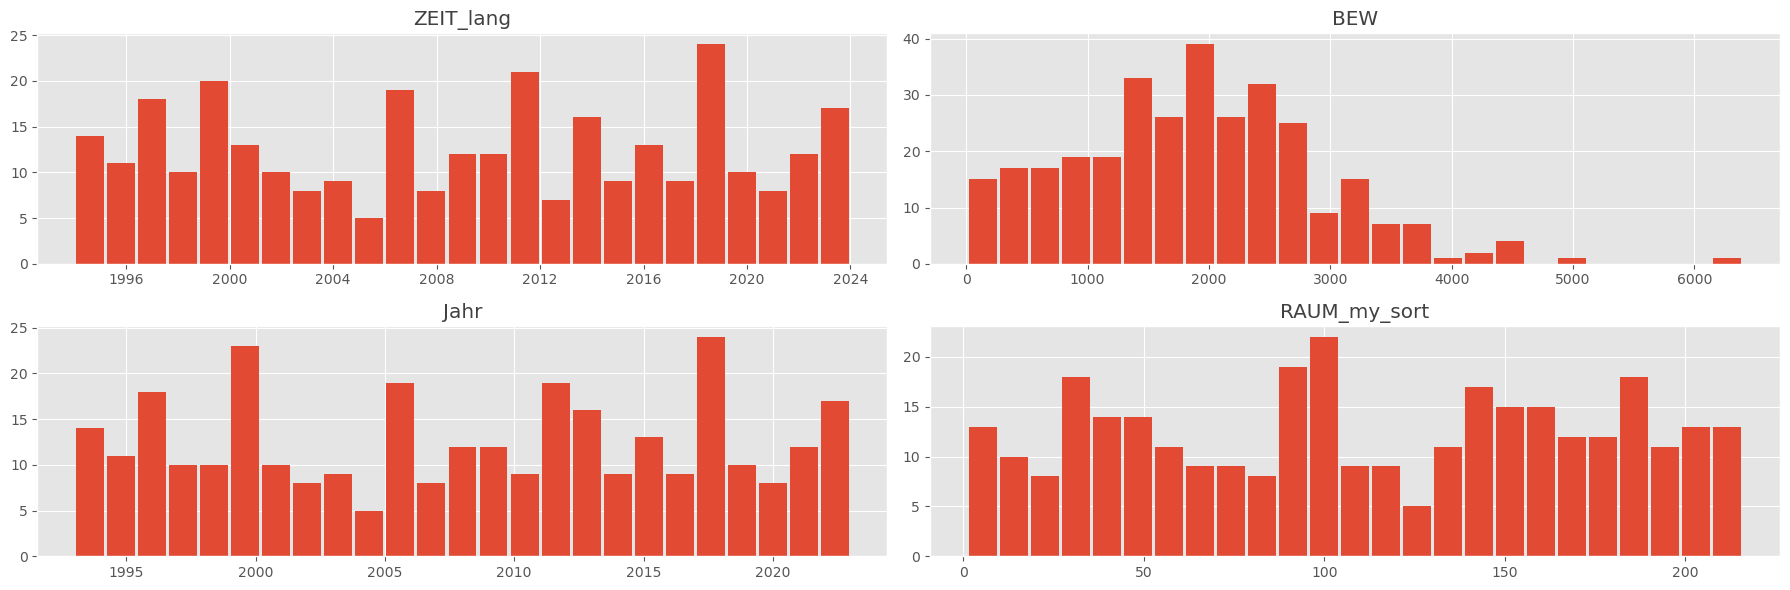

In [30]:
plt.style.use('ggplot')
params = {
    'text.color': (0.25, 0.25, 0.25),
    'figure.figsize': [18, 6],
   }
plt.rcParams.update(params)

try:
    data2betested.hist(bins=25, rwidth=0.9)
    plt.tight_layout()
    plt.show()
except:
    print("No numercial data to plot.") 

### Gibt es Duplikate?

In [31]:
# find duplicate rows
duplicate_rows = data2betested[data2betested.duplicated()]
duplicate_rows

,ZEIT_lang,ZEIT_code,RAUM_lang,RAUM_code,BEW,StichtagDatJahr_str,Jahr,RAUM_my_sort
StichtagDatJahr,,,,,,,,


### Nullwerte und Missings?

In [32]:
data2betested.isnull().sum()

ZEIT_lang              0
ZEIT_code              0
RAUM_lang              0
RAUM_code              0
BEW                    0
StichtagDatJahr_str    0
Jahr                   0
RAUM_my_sort           0
dtype: int64

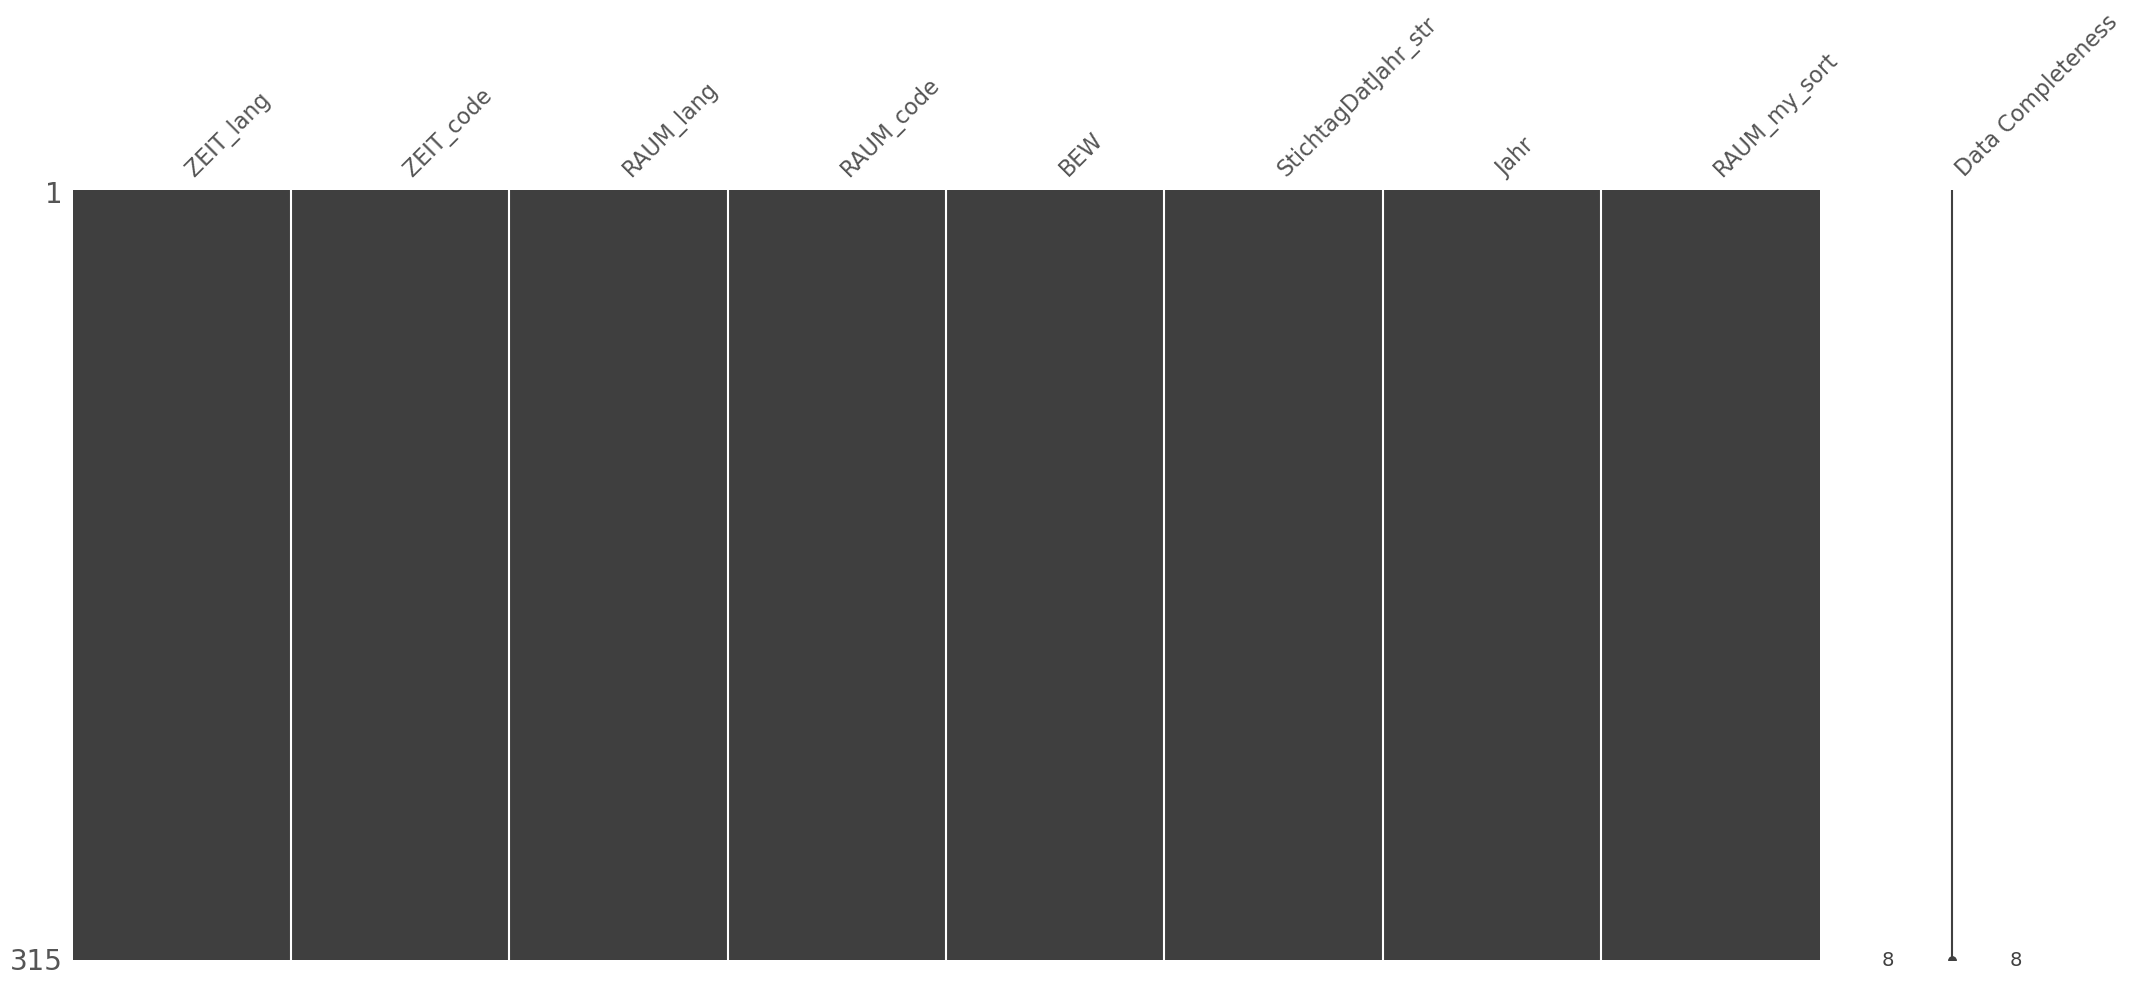

In [33]:
# check missing values with missingno
# https://github.com/ResidentMario/missingno
import missingno as msno
msno.matrix(data2betested, labels=True, sort='descending');
#msno.heatmap(data2betested)

### Gruppierungen

In [34]:
agg_jahr = data2betested.loc[data_min_date:data_max_date]\
    .groupby(['Jahr']) \
    .agg(sum_AnzBestWir=('BEW', 'sum')) \
    .sort_values('Jahr', ascending=False) 
agg_jahr.reset_index().head(3)

,Jahr,sum_AnzBestWir
0,2023,20627
1,2022,20162
2,2021,22999


In [35]:
data2betested.RAUM_lang.unique()

array(['Felsenrain', 'Museum Rietberg', 'Zwinglihaus', 'Hürst', 'Klus',
       'Letzigraben', 'Seminarstrasse', 'Tulpenstrasse', 'Merkurplatz',
       'Dolder', 'Beckenhof', 'Scheuchzerstrasse', 'Güterbahnhof',
       'Sihlporte', 'Oberdorf', 'Central', 'Bahnhof Wollishofen',
       'Saalsporthalle', 'Schaufelbergerstrasse', 'Bolleystrasse',
       'Dunkelhölzli', 'Hönggerberg', 'Ettenfeld', 'Grünhaldenstrasse',
       'Mattenhof', 'Kalchbühl', 'Kongresshaus', 'Sihlhölzli',
       'Volkshaus', 'Nordheim', 'Weinbergstrasse', 'Krone',
       'Seeblickstrasse', 'Riedtli', 'Culmannstrasse', 'Imbisbühlstrasse',
       'Zschokkestrasse', 'Rosengartenstrasse', 'Dreispitz',
       'Bocklerstrasse', 'Drahtschmidli', 'Grossmünster', 'Schipfe',
       'Manesseplatz', 'Berufsschulen', 'Buchzelgstrasse', 'Guggach',
       'Wildbachstrasse', 'In der Ey', 'Reckenholz', 'KV-Business School',
       'Münsterhof', 'Heuried', 'Gehrenholz', 'Susenberg', 'Letzistrasse',
       'Carl Spitteler-Strasse', 'Al

In [36]:
agg_StaZ = data2betested.loc[data_min_date:data_max_date]\
    .groupby(['RAUM_my_sort', 'RAUM_lang', 'RAUM_code']) \
    .agg(sum_AnzBestWir=('BEW', 'sum')) \
    .sort_values('RAUM_code', ascending=True) 
agg_StaZ.reset_index().head(40)

,RAUM_my_sort,RAUM_lang,RAUM_code,sum_AnzBestWir
0,1,Zähringerstrasse,R3Z001,539
1,3,Grossmünster,R3Z003,1814
2,4,Oberdorf,R3Z004,2737
3,5,Central,R3Z005,1125
4,6,ETH / Universität,R3Z006,52
5,7,Bellevue,R3Z007,264
6,9,Schipfe,R3Z009,465
7,10,Münsterhof,R3Z010,962
8,11,Stadthaus,R3Z011,43
9,12,Bahnhofplatz,R3Z012,33


In [37]:
data2betested.columns

Index(['ZEIT_lang', 'ZEIT_code', 'RAUM_lang', 'RAUM_code', 'BEW', 'StichtagDatJahr_str', 'Jahr',
       'RAUM_my_sort'],
      dtype='object')

### Zeitpunkte und Zeiträume abfragen

A particular powerful feature of the Pandas DataFrame is its indexing capability that also works using time-based entities, such as dates and times. We have already created the index above, so let's put it to use.

In [38]:
data2betested.loc[data_max_date].head(2)
#data2betested.loc["2021-10-31":"2021-11-30"].head(2)

,ZEIT_lang,ZEIT_code,RAUM_lang,RAUM_code,BEW,StichtagDatJahr_str,Jahr,RAUM_my_sort
StichtagDatJahr,,,,,,,,
2023-12-31,2023-12-31,Z31122023,Ausserdorfstrasse,R3Z200,866,2023-12-31,2023,200
2023-12-31,2023-12-31,Z31122023,Albin Zollinger-Platz,R3Z188,3500,2023-12-31,2023,188


### Visualisierungen nach Zeitausschnitten

#### Entwicklung Wohnbevölkerung seit ...

In [39]:
myAggAll = data2betested.loc[data_min_date:data_max_date]\
    .groupby(['StichtagDatJahr']) \
    .agg(sum_WBev=('BEW', 'sum')) \
    .sort_values('StichtagDatJahr', ascending=False) 

myAggAll.reset_index().head(20)

,StichtagDatJahr,sum_WBev
0,2023-12-31,20627
1,2022-12-31,20162
2,2021-12-31,22999
3,2020-12-31,14991
4,2019-12-31,22701
5,2018-12-31,15907
6,2017-12-31,29223
7,2016-12-31,16325
8,2015-12-31,32510
9,2014-12-31,15356


In [40]:
myTitle="Bevölkerungsentwicklung, seit "+str(data2betested.index.year.min())

highlight = alt.selection(type='single', on='mouseover',
                          fields=['sum_WBev'], nearest=True)
#x='date:StichtagDatJahr',
base = alt.Chart(myAggAll.reset_index().query('sum_WBev>30'), title=myTitle).encode(
    x=alt.X('StichtagDatJahr', axis=alt.Axis(title='Jahr'))# , axis=alt.Axis(format='%', title='percentage')
    , y=alt.X('sum_WBev', axis=alt.Axis(title='Anz. Personen'))
    #, color=alt.Color('QuarLang', legend=alt.Legend(title="Altersgruppen", orient="right"))  
    ,tooltip=['StichtagDatJahr','sum_WBev']    
)
points = base.mark_circle().encode(
    opacity=alt.value(0.75)
).add_selection(
    highlight
).properties(
    width=750 , height=350
)
lines = base.mark_line().encode(
    size=alt.condition(~highlight, alt.value(0.5), alt.value(4))
).interactive()

lines + points

alt.LayerChart(...)

#### Entwicklung Wohnbevölkerung nach Stadtquartier seit ...

In [41]:
data2betested.columns

Index(['ZEIT_lang', 'ZEIT_code', 'RAUM_lang', 'RAUM_code', 'BEW', 'StichtagDatJahr_str', 'Jahr',
       'RAUM_my_sort'],
      dtype='object')

In [42]:
#myAgg = data2betested.loc["2008-11-30":"2021-10-31"]
myAgg = data2betested.loc[data_min_date:data_max_date]\
    .groupby(['StichtagDatJahr', 'RAUM_my_sort','RAUM_lang', 'RAUM_code']) \
    .agg(sum_WBev=('BEW', 'sum')) \
    .sort_values('StichtagDatJahr', ascending=True) 

myAgg.reset_index().head(3)

,StichtagDatJahr,RAUM_my_sort,RAUM_lang,RAUM_code,sum_WBev
0,1993-12-31,34,Museum Rietberg,R3Z034,2803
1,1993-12-31,55,Zwinglihaus,R3Z055,3588
2,1993-12-31,87,Seminarstrasse,R3Z087,1538


In [43]:

myTitle="Bevölkerung nach Statistischer Zone, seit "+str(data2betested.index.year.min())
highlight = alt.selection(type='single', on='mouseover',
                          fields=['RAUM_lang'], nearest=True)
#x='date:StichtagDatJahr',
base = alt.Chart(myAgg.reset_index().query('RAUM_my_sort>100'), title=myTitle).encode(
    x=alt.X('StichtagDatJahr', axis=alt.Axis(title='Jahr'))# , axis=alt.Axis(format='%', title='percentage')
    , y=alt.X('sum_WBev', axis=alt.Axis(title='Anz. Personen'))
    , color=alt.Color('RAUM_lang', legend=alt.Legend(title="Stadtquartier", orient="right"))  
    ,tooltip=['StichtagDatJahr', 'RAUM_lang','RAUM_my_sort','sum_WBev']    
)
points = base.mark_circle().encode(
    opacity=alt.value(0.75)
).add_selection(
    highlight
).properties(
    width=750 , height=350
)
lines = base.mark_line().encode(
    size=alt.condition(~highlight, alt.value(0.5), alt.value(4))
).interactive()

lines + points

alt.LayerChart(...)

#### Entwicklung Wohnbevölkerung nach Statistischen Zonen

In [44]:
#myAgg = data2betested.loc["2008-11-30":"2021-10-31"]
myAgg = data2betested.loc[data_min_date : data_max_date]\
    .groupby(['StichtagDatJahr', 'RAUM_code', 'RAUM_lang', 'RAUM_my_sort']) \
    .agg(sum_WBev=('BEW', 'sum')) \
    .sort_values('StichtagDatJahr', ascending=True) 

myAgg.reset_index().head(3)


,StichtagDatJahr,RAUM_code,RAUM_lang,RAUM_my_sort,sum_WBev
0,1993-12-31,R3Z034,Museum Rietberg,34,2803
1,1993-12-31,R3Z055,Zwinglihaus,55,3588
2,1993-12-31,R3Z087,Seminarstrasse,87,1538


In [45]:
myTitle="Entwicklung Wohnbevölkerung nach Statistischen Zonen (>200), "+data_min_date +" - "+data_max_date

highlight = alt.selection(type='single', on='mouseover',
                          fields=['RAUM_lang'], nearest=True)
#x='date:StichtagDatJahr',
base = alt.Chart(myAgg.reset_index().query('RAUM_my_sort > 200'), title=myTitle).encode(
    x=alt.X('StichtagDatJahr', axis=alt.Axis(title='Jahr'))# , axis=alt.Axis(format='%', title='percentage')
    , y=alt.X('sum_WBev', axis=alt.Axis(title='Anz. Personen'))
    , color=alt.Color('RAUM_lang', legend=alt.Legend(title="Stadtquartier", orient="right"))  
    ,tooltip=['StichtagDatJahr', 'RAUM_lang','sum_WBev']    
)
points = base.mark_circle().encode(
    opacity=alt.value(0.75)
).add_selection(
    highlight
).properties(
    width=750 , height=350
)
lines = base.mark_line().encode(
    size=alt.condition(~highlight, alt.value(0.5), alt.value(4))
).interactive()

lines + points

alt.LayerChart(...)

#### Barcharts mit Seaborn

In [46]:
#myAgg = data2betested.loc["2008-11-30":"2021-10-31"]
myAggBar = data2betested.loc[data_min_date:data_max_date]\
    .groupby(['StichtagDatJahr','Jahr', 'RAUM_lang', 'RAUM_code', 'RAUM_my_sort']) \
    .agg(sum_WBev=('BEW', 'sum')) \
    .sort_values('StichtagDatJahr', ascending=True) 

myAggBar.reset_index().head(3)

,StichtagDatJahr,Jahr,RAUM_lang,RAUM_code,RAUM_my_sort,sum_WBev
0,1993-12-31,1993,Felsenrain,R3Z198,198,1491
1,1993-12-31,1993,Hürst,R3Z184,184,2807
2,1993-12-31,1993,Klus,R3Z116,116,2239


In [47]:
#help(sns.catplot)     

In [48]:
#Stile for the following sns graphs
sns.set_theme(style="whitegrid")


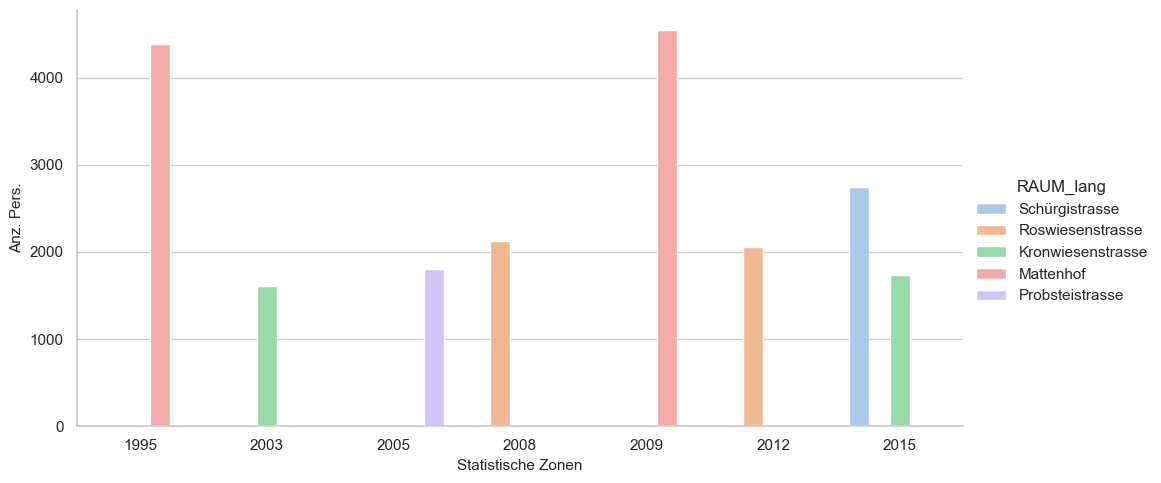

In [49]:
#sns.color_palette("flare", as_cmap=True)
myHist = sns.catplot(x="Jahr"
            , y="sum_WBev"
            , hue="RAUM_lang"
            , kind="bar" #boxen, violin, --> wenn die aggregation nicht genau den werten in der grafik entspricht
            , palette="pastel" #, color="green"
            , height=5
            , aspect=2
            , order=None, legend_out=True
            ,data=myAggBar.reset_index().query('RAUM_my_sort > 210').sort_values("RAUM_code", ascending=True)
           )
myHist.set_xlabels('Statistische Zonen', fontsize=11) # not set_label
myHist.set_ylabels('Anz. Pers.', fontsize=11)


In [50]:
myAggBar2 = data2betested.loc[data_min_date:data_max_date]\
    .groupby(['Jahr','StichtagDatJahr_str', 'RAUM_lang', 'RAUM_code', 'RAUM_my_sort']) \
    .agg(sum_WBev=('BEW', 'sum')) \
    .sort_values('RAUM_my_sort', ascending=True) 

myAggBar2

,,,,,sum_WBev
Jahr,StichtagDatJahr_str,RAUM_lang,RAUM_code,RAUM_my_sort,
2000,2000-12-31,Zähringerstrasse,R3Z001,1,539
1997,1997-12-31,Grossmünster,R3Z003,3,907
2004,2004-12-31,Grossmünster,R3Z003,3,907
1995,1995-12-31,Oberdorf,R3Z004,4,667
2016,2016-12-31,Oberdorf,R3Z004,4,712
...,...,...,...,...,...
2015,2015-12-31,Kronwiesenstrasse,R3Z213,213,1736
2003,2003-12-31,Kronwiesenstrasse,R3Z213,213,1607
1995,1995-12-31,Mattenhof,R3Z215,215,4393


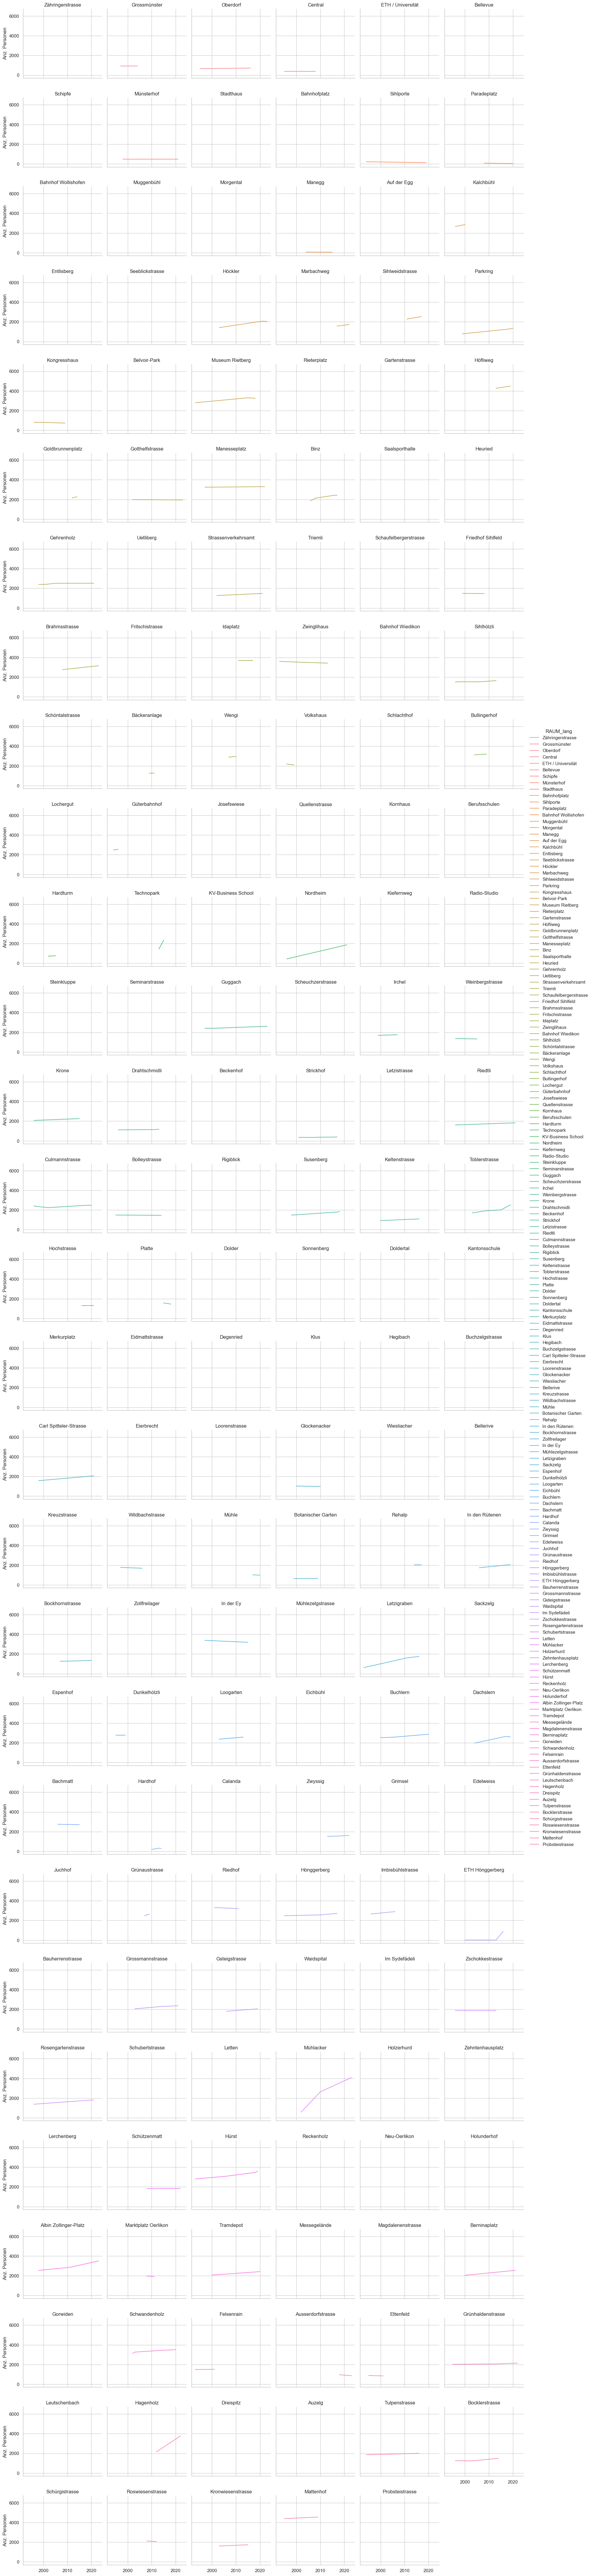

In [51]:
g2 = sns.FacetGrid(myAggBar2.reset_index(), col="RAUM_lang", hue="RAUM_lang", col_wrap=6, height=3,)
g2.map(sns.lineplot, "Jahr","sum_WBev",alpha=.8)

g2.set_axis_labels("","Anz. Personen")
g2.set_titles(col_template="{col_name}", row_template="{row_name}")

g2.add_legend()


## ---------------------- hier Plausi beendet

Übersicht zu LOSD-Jobs:
[Sharepoint](https://kollaboration.intranet.stzh.ch/orga/ssz-produkte/Lists/SASA_Outputs/OGD%20Metadaten.aspx#InplviewHasheb69a2c0-ed94-4ef2-91a5-3b19f038e442=FilterField1%3DMetadaten%255Fx002d%255FPublikations%255Fx00-FilterValue1%3DINT)